# TD 4 : Neural networks

## Objectif

On se propose dans ce TP de comprendre les fonctionnalités des réseaux de neurones, d’introduire la bibliothèque **PyTorch**, de créer un réseau de neurones simple pour une tâche de classification, et de mettre en œuvre ou d’utiliser des outils de visualisation et des métriques de performance pour évaluer les résultats de l’entraînement.

Cela inclut l’implémentation des éléments suivants :  
- La description du réseau de neurones  
- La boucle d’optimisation  
- Les phases de test et d’évaluation  



# Réseaux de neurones avec PyTorch

## Libraries

Il s'agit d'un premier contact avec [PyTorch](https://pytorch.org/), l'une des frameworks de Deep Learning les plus utilisés (avec [TensorFlow](https://www.tensorflow.org/?hl=fr)).

[PyTorch](https://pytorch.org/) propose une bibliothèque de tenseurs, des fonctions mathématiques, des couches de deep learning et des outils pour concevoir et entraîner des modèles complexes. Bien que la majeure partie de cette séance pratique puisse être réalisée avec Numpy, nous avons choisi de nous concentrer sur PyTorch pour plusieurs raisons :  
- Il permet de basculer vers des calculs sur GPU si nécessaire (les opérations parallèles sur GPU rendent les calculs plus efficaces, bien que cela ne soit pas indispensable pour ce TP).  
- De nombreux optimiseurs, de Dataloaders  et couches sont déjà implémentés, ce qui permettra un codage rapide des modèles de deep learning.


In [63]:
# The standard numpy & visualization libraries
import numpy as np
import matplotlib.pyplot as plt

# Pytorch
import torch

# Library for displaying progress bars
from tqdm import tqdm, tnrange

In [64]:
print("NUMPY ----")
data_np = np.ones((10,7), dtype=np.float32) # defintion of a Matrix shape (10,7) with ones inside
data_np[0] = 0 # set first line to 0
data_np[5:7, 2:3] = 5 # slicing to set the values
print(data_np)
print(np.tanh(data_np)) # call a function
data_np = np.expand_dims(data_np, axis=2) # adding a dimension
print(data_np.shape)
# convert from float to long int
data_np = data_np.astype(np.int64)
# convert from int to float
data_np = data_np.astype(np.float32)

print("PYTORCH ----")
data_pt = torch.ones((10,7), dtype=torch.float)
data_pt[0] = 0
data_pt[5:7, 2:3] = 5
print(data_pt)
print(torch.tanh(data_pt)) # call a function
data_pt = data_pt.unsqueeze(2) # adding a dimension
print(data_pt.shape)
# convert from float to int
data_pt = data_pt.long()
# convert from int to float
data_pt = data_pt.float()

# conversion from PyTorch to Numpy
data = data_pt.numpy()

# conversion from Numpy to PyTorch
data = torch.tensor(data_np)

NUMPY ----
[[0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 5. 1. 1. 1. 1.]
 [1. 1. 5. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
[[0.        0.        0.        0.        0.        0.        0.       ]
 [0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942]
 [0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942]
 [0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942]
 [0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942]
 [0.7615942 0.7615942 0.9999092 0.7615942 0.7615942 0.7615942 0.7615942]
 [0.7615942 0.7615942 0.9999092 0.7615942 0.7615942 0.7615942 0.7615942]
 [0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942]
 [0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942]
 [0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942 0.7615942]]
(10, 7, 1)
PYTORC

## Analyse de données

Le code ci- dessous génère six ensembles de données synthétiques pour analyser les complexités associées aux problèmes de classification. Chaque ensemble de données est généré en utilisant une fonction spécifique pour simuler des distributions de données ayant des caractéristiques variées.

1. **Deux lunes (`make_moons`)** : Cet ensemble génère deux clusters en forme de lune entrelacées, ce qui représente un problème non linéaire de classification relativement simple.

2. **Deux cercles (`make_circles`)** : Les données se répartissent en deux cercles concentriques, un autre exemple de problème de classification non linéaire.

3. **Deux groupes de blobs (`make_blobs`)** : Quatre groupes de points (blobs) sont générés et regroupés par paires pour former deux classes. Ce problème est plus simple, car les données sont généralement linéairement séparables.

4. **Deux spirales** : Cet ensemble génère deux spirales entrelacées, un problème complexe et non linéaire où les classes sont difficiles à séparer.

5. **Quatre cercles** : Deux paires de cercles concentriques sont générées, ajoutant une complexité supplémentaire en introduisant des classes supplémentaires dans un espace structuré.

6. **Quatre lunes** : Une extension des deux lunes avec deux clusters supplémentaires décalés, augmentant la difficulté de séparation.




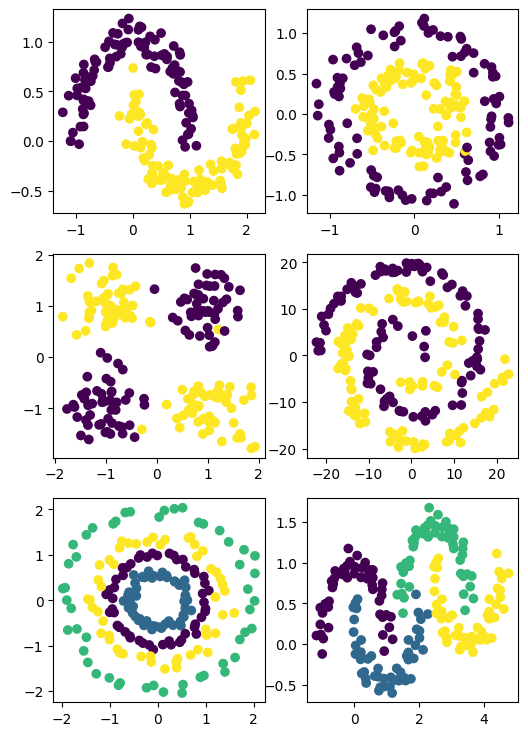

In [65]:
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.model_selection import train_test_split
import math

def generate_data(data_num, nsamples = 500, random_state = 0):
  if data_num == 0: # Two moons
    X,y  = make_moons(n_samples=nsamples, noise=0.1, random_state=random_state)
  elif data_num == 1: # Two circles
    X,y = make_circles(n_samples=nsamples, factor=0.5, noise=0.1, random_state=random_state)
  elif data_num == 2: # Two sets of two blobs
    X,y = make_blobs(n_samples=nsamples,centers=[[1,1],[-1,-1],[1,-1],[-1,1]],
                     cluster_std=0.4, random_state=random_state)
    y = y//2
  elif data_num == 3: # Two spirals
    L = 3

    N = nsamples//2
    theta = np.sqrt(np.random.rand(N))*L*math.pi
    r_a = 2*theta + math.pi
    data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
    x_a = data_a + np.random.randn(N,2)
    res_a = np.append(x_a, np.zeros((N,1)), axis=1)

    N = nsamples - nsamples//2
    theta = np.sqrt(np.random.rand(N))*L*math.pi
    r_b = -2*theta - math.pi
    data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
    x_b = data_b + np.random.randn(N,2)
    res_b = np.append(x_b, np.ones((N,1)), axis=1)

    res = np.append(res_a, res_b, axis=0)
    np.random.shuffle(res)

    X = res[:,:2]
    y = res[:,2]
  elif data_num == 4: # Four circles
    X,y = make_circles(n_samples=nsamples//2, factor=0.6, noise=0.05, random_state=random_state)
    # ax[1,1].scatter(X[:, 0], X[:, 1], c=y)
    X2,y2 = make_circles(n_samples=nsamples - nsamples//2, factor=0.7, noise=0.05, random_state=random_state+1)
    X = np.vstack((X,2*X2))
    y = np.hstack((y,2+y2))
  elif data_num == 5: # Four moons
    X,y  = make_moons(n_samples=nsamples//2, noise=0.1, random_state=random_state)
    X2,y2  = make_moons(n_samples=nsamples-nsamples//2, noise=0.1, random_state=random_state)
    X2[:, 0] += 2.5
    X2[:, 1] += 0.5
    X = np.vstack((X,X2))
    y = np.hstack((y,2+y2))
  else:
    X,y = make_blobs(n_samples=nsamples,centers=[[1,1],[-1,-1]], cluster_std=0.9,random_state=random_state)

  return X,y

idataset = 0
X,y = generate_data(idataset, nsamples=200, random_state = 42)

#### Put a visualization code here
_, axs = plt.subplots(nrows = 3, ncols=2, sharex=False, sharey=False, figsize=(6, 9))

for i,ax in enumerate(axs.ravel()):
  X,y = generate_data(i, nsamples=200, random_state = 42)
  ax.scatter(X[:, 0], X[:, 1], c=y)


## Ensembles d'entraînement et de test

La première activité consiste à utiliser PyTorch pour calculer un classifieur linéaire en utilisant la fonction de perte *Binary Cross Entropy* sur un problème simple.  

Le code suivant crée les ensembles d'entraînement et de test et les transforme en tenseurs.


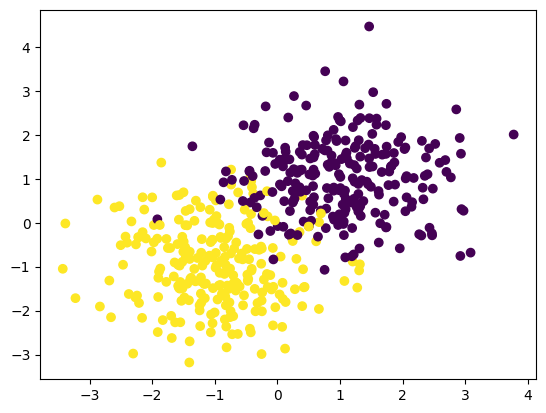

In [66]:
# dataset: two blobs
idataset = -1
X,y = generate_data(idataset, nsamples=500, random_state = 42)

# Create train and test sets as tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_pts, train_labels = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
test_pts, test_labels = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

plt.scatter(X[:, 0], X[:, 1], c=y)

## Définition du réseau de neurones

En PyTorch, un réseau est défini comme un objet qui hérite de méthodes prédéfinies utilisées pour l'apprentissage (le [**`torch.nn.Module`**](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)).

En pratique, il faut décrire :  
- Les couches (définies comme des variables dans la méthode **`__init__`**)  
- L'architecture, c’est-à-dire la séquence des calculs qui produit la sortie à partir de l’entrée (la méthode **`forward`**).  




In [67]:
# Definition of a simple network
class NetworkExample(torch.nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.l1 = torch.nn.Linear(2,1)

    def forward(self, x):

        y = self.l1(x)

        return y

L'architecture du réseau est accessible en utilisant `state_dict()`.


In [69]:
net = NetworkExample()
print(net.state_dict())

OrderedDict([('l1.weight', tensor([[-0.6245, -0.3603]])), ('l1.bias', tensor([-0.0215]))])


En PyTorch, l'architecture du réseau et ses paramètres (poids et biais) sont accessibles via la méthode `state_dict()`. Lors de l'initialisation d'un réseau, les valeurs des poids et biais sont générées aléatoirement, ce qui explique les différences observées entre deux exécutions consécutives. Ces paramètres aléatoires servent de point de départ pour l'entraînement du modèle, où ils seront ajustés pour minimiser la fonction de perte.


## Phase d'Apprentissage

La phase d'apprentissage nécessite plusieurs fonctionnalités complémentaires à définir une fois le réseau créé et initialisé :
- la fonction de perte d'apprentissage
- le taux d'apprentissage (Learning rate)
- la stratégie d'échantillonnage des données
- ...

La cellule suivante propose une fonction d'apprentissage plutôt générique adaptée à la classification binaire.


In [70]:
# Learning phase
def model_trainer_binary(model, optimizer, data_train, epochs=5, verbose=True):

  train_pts = data_train[0]
  train_labels = data_train[1]

  # Epoch: the number of times we see the entire dataset
  num_epoch = epochs

  # optimizer creation
  optimizer = optimizer

  # loss criterion
  criterion = torch.nn.BCEWithLogitsLoss()

  losses = []
  iterations = []
  total_iter_counter = 0
  for epoch in range(num_epoch):

      # set the network in training mode
      model.train()

      # create an iterator with progress bar
      t = tqdm(torch.randperm(train_pts.shape[0]))

      # variable to track the loss
      total_loss = 0

      epoch_iter_counter = 0

      # training loop
      for epoch_iter_counter,i in enumerate(t):

          # create the input / target tensors
          x = train_pts[i].reshape(1, 2)
          target = train_labels[i].reshape(1,1).float()

          # forward step
          y2 = model(x)

          # compute error loss
          loss = criterion(y2, target)

          # initialize the gradients to zero
          optimizer.zero_grad()

          # compute the backward pass
          loss.backward()

          # update the weights
          optimizer.step()

          # get the loss for the example and add it to the total loss
          total_loss += loss.item()
          #epoch_iter_counter += 1

          # print the average loss in the progress bar
          if verbose:
            t.set_description_str(f"Loss={total_loss/(1+epoch_iter_counter):.4e}")

          total_iter_counter += 1

      # Compute the loss over one epoch
      total_loss /= train_pts.shape[0]

      # Increment the loss sequence
      losses.append(total_loss)
      iterations.append(total_iter_counter)

  return (iterations, losses)


## Optimisation du réseau

Une fois l'apprentissage défini, il faut démarrer l'optimisation proprement dite pour apprendre les poids.

Loss=1.2043e-01: 100%|██████████| 335/335 [00:01<00:00, 207.15it/s]


Text(0, 0.5, 'Loss')

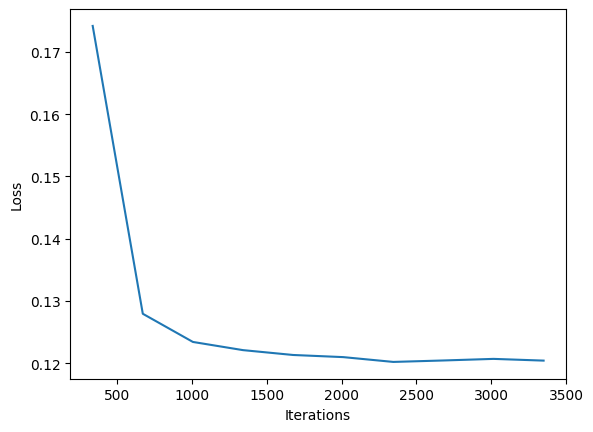

In [71]:
# Create the network
net = NetworkExample()

# Define the optimization strategy
lr = 1e-1
optimizer = torch.optim.SGD(net.parameters(), lr)

# Learn and get the loss curves
learning_curves = model_trainer_binary(net, optimizer, (train_pts, train_labels),
              epochs=10, verbose=True)

# display the loss evolution
plt.figure()
plt.plot(learning_curves[0], learning_curves[1])
plt.xlabel('Iterations')
plt.ylabel('Loss')


L'output de la phase d'apprentissage montre l'évolution de la perte au cours des itérations d'apprentissage. On observe une courbe qui commence à une valeur relativement élevée, puis diminue rapidement au début, indiquant que le modèle apprend bien. La perte atteint une valeur plus stable et faible à la fin des itérations, ce qui est un signe que le modèle se rapproche de la solution optimale. La barre de progression permet de suivre l'avancée de chaque itération, et la valeur de la perte est affichée à chaque étape, ce qui donne une indication claire de la performance du modèle à chaque époque. L'output graphique en haut permet de visualiser cette évolution de la perte, montrant comment elle se stabilise après plusieurs itérations.

Cela montre que l'apprentissage est efficace et que le modèle est en train de converger.


La cellule suivante contient une fonction permettant d'afficher la surface de décision une fois le réseau appris.

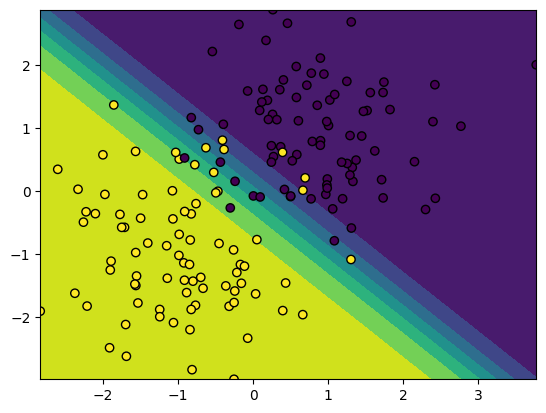

In [72]:
from sklearn.inspection import DecisionBoundaryDisplay

# Function for displaying decision surface
def display_2D_boundary(model, # network
                        points, # Evaluation data (pts, labels)
                        head = None, # If a decision layer is needed
                        pred_show = False # Shows decision regions rather than score
                        ):

  model.eval()

  pt_min = points[0].min(0).values.numpy()
  pt_max = points[0].max(0).values.numpy()
  feature_1, feature_2 = np.meshgrid(np.linspace(pt_min[0],pt_max[0]),np.linspace(pt_min[1],pt_max[1]))

  grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
  grid_t = torch.tensor(grid, dtype=torch.float32)

  with torch.no_grad():
    if head is not None:
      grid_pred = head(model(grid_t)).detach()
    else:
      grid_pred = model(grid_t).detach()

  if pred_show:
      grid_pred = (grid_pred > 0.5).long()

  y_pred = np.reshape(grid_pred, feature_1.shape)

  display = DecisionBoundaryDisplay(xx0=feature_1,
                                    xx1=feature_2,
                                    response=y_pred)
  display.plot()

  display.ax_.scatter(points[0][:, 0], points[0][:, 1], c=points[1], edgecolor="black")

display_2D_boundary(net, (test_pts, test_labels), head = torch.sigmoid, pred_show = False)

Le réseau semble bien performer, avec une séparation nette entre les classes dans la surface de décision. Toutefois, quelques points proches de la frontière sont mal classés, ce qui peut indiquer de petites erreurs de classification.

## Une autre Base de données

Dans cette section, Nous allons étudier le même réseau sur le problème des "deux lunes".

Loss=2.5851e-01: 100%|██████████| 335/335 [00:01<00:00, 297.61it/s]


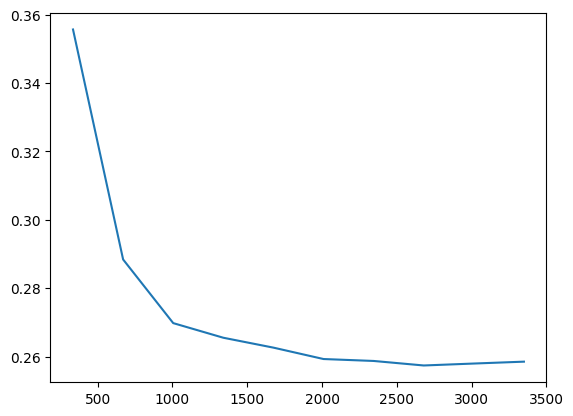

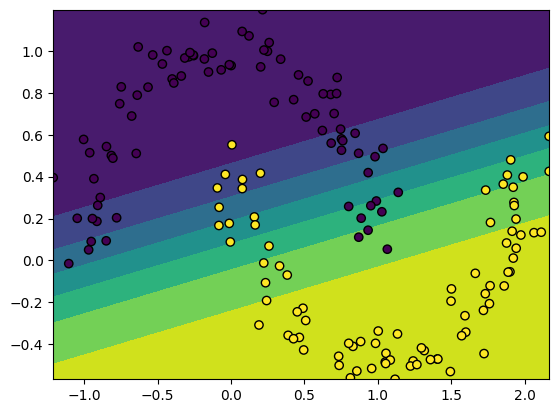

In [73]:
# dataset: two moons
idataset = 0
X,y = generate_data(idataset, nsamples=500, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_pts, train_labels = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
test_pts, test_labels = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create network
net = NetworkExample()

lr = 1e-1
optimizer = torch.optim.SGD(net.parameters(), lr)

learning_curves = model_trainer_binary(net, optimizer, (train_pts, train_labels),
              epochs=10, verbose=True)

# display the loss evolution
plt.figure()
plt.plot(learning_curves[0], learning_curves[1])

display_2D_boundary(net, (test_pts, test_labels), head = torch.sigmoid, pred_show = False)

Le comportement du réseau sur ce jeu de données montre qu'il n'est pas un bon séparateur si on le compare au cas précédent. En effet, la surface de décision n'arrive pas à bien séparer les deux classes, surtout au niveau de la frontière. Les points sont mal classés autour de cette zone, et le modèle semble trop linéaire pour ce problème qui a une nature non linéaire . Cela suggère que le réseau pourrait nécessiter une architecture plus complexe ou un meilleur ajustement pour mieux capturer cette distribution.

## Adaptation d'Architecture

Une question cruciale lors de l'utilisation des réseaux de neurones est de trouver une bonne architecture qui puisse approximativement la fonction de décision, mais aussi qui puisse être apprise à l'aide de la descente de gradient.

Dans cette activité, nous allons modifier le réseau. Pour ce faire, nous avons ajouté une couche au réseau en modifiant sa définition pour qu'il devienne un réseau à trois couches . La fonction d'activation (entre les couches linéaires) utilisée est la tangente hyperbolique (`torch.tanh`). Les paramètres du réseau sont la taille de l'entrée (`input size`), la taille cachée (`hidden size`) et la taille de la sortie (`output size`).




In [74]:
# Definition of the network
class NetworkTwoLayers(torch.nn.Module):
    def __init__(self, in_size, hidden_size, out_size, activation = torch.tanh) -> None:
        super().__init__()
        self.activation = activation
        self.l1 = torch.nn.Linear(in_size, hidden_size)
        self.l2 = torch.nn.Linear(hidden_size, out_size)

    def forward(self, x):
        y = self.l1(x)
        y = self.activation(y)
        y = self.l2(y)

        return y

In [75]:
# dataset
idataset = 0
X,y = generate_data(idataset, nsamples=500, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_pts, train_labels = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
test_pts, test_labels = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create the network
net = NetworkTwoLayers(2, 8, 1, activation=torch.relu)


Loss=1.0664e-02: 100%|██████████| 335/335 [00:01<00:00, 248.14it/s]


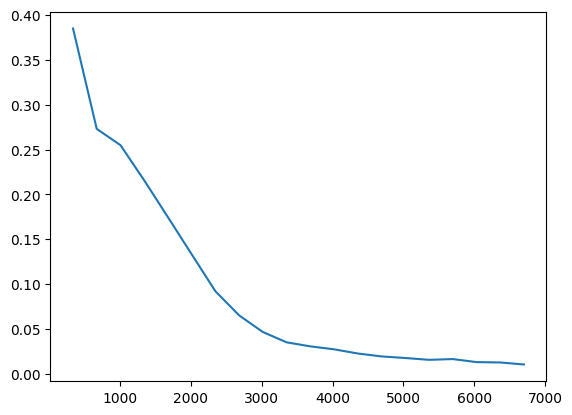

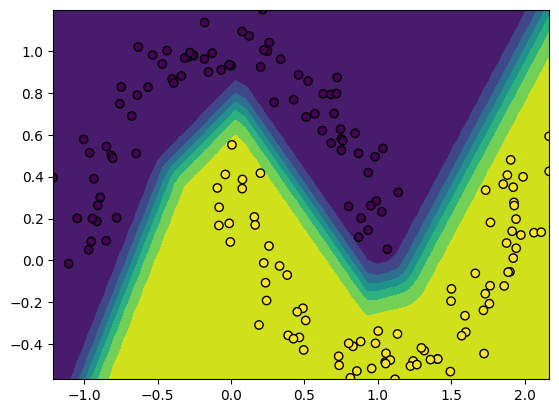

In [76]:
# Optimization
lr = 1e-1
optimizer = torch.optim.SGD(net.parameters(), lr)

learning_curves = model_trainer_binary(net, optimizer, (train_pts, train_labels),
              epochs=20, verbose=True)

# display the loss evolution
plt.figure()
plt.plot(learning_curves[0], learning_curves[1])

display_2D_boundary(net, (test_pts, test_labels), head = torch.sigmoid, pred_show = False)

Le modèle est entraîné sur la base de données "The Two Moons" . Après l'ajout d'une couche supplémentaire, le comportement du réseau sur ce jeu de données montre qu'il est un bon séparateur. En effet, la surface de décision a ajusté la frontière de séparation, corrigeant ainsi les points mal classés et améliorant la performance globale du modèle.

## Ajout du nombre de couches

### Impact du nombre de couches sur l'architecture

Nous allons évaluer l'impact du nombre de couches dans l'architecture.

Pour une architecture contenant une ou deux couches cachées et le même nombre de neurones cachés `nh`, le nombre de poids et de biais est le suivant :

- **Une couche cachée** : $ (2 * nh + nh) + (nh + 1) = 4nh+1$
  
- **Deux couches cachées** : $ (2*nh + nh) + (nh * nh + nh) + (nh+1) = nh^2+5nh+1$

Le code ci-dessous affiche un graphique qui montre le nombre de poids et de biais dans deux architectures de réseaux de neurones : l'une avec une couche cachée et l'autre avec deux couches cachées, en fonction de la taille de la couche cachée (`Hidden size`).




Text(0, 0.5, 'Number of weights & biases')

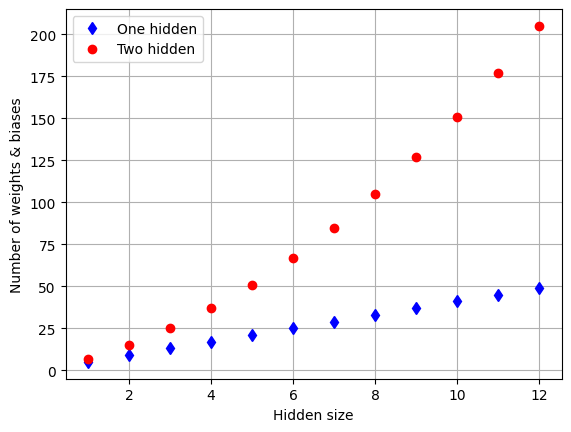

In [77]:
hsize = np.arange(1,13,1)

onelayer = [1]*12
twolayer = [2]*12

onelayer = 4*hsize+1
twolayer = hsize*hsize+5*hsize+1


plt.plot(hsize, onelayer, 'bd', label='One hidden')
plt.plot(hsize, twolayer, 'ro', label='Two hidden')
plt.legend()
plt.grid(True)
plt.xlabel('Hidden size')
plt.ylabel('Number of weights & biases')


In [82]:
# Performance d'un réseau de neurones à deux couches cachées

class NetworkThreeLayers(torch.nn.Module):

    def __init__(self, in_size, hidden_size, out_size, activation = torch.tanh) -> None:
        super().__init__()
        self.activation = activation
        self.l1 = torch.nn.Linear(in_size, hidden_size)
        self.l2 = torch.nn.Linear(hidden_size, hidden_size)
        self.l3 = torch.nn.Linear(hidden_size, out_size)

    def forward(self, x):

        y = self.l1(x)
        y = self.activation(y)
        y = self.l2(y)
        y = self.activation(y)
        y = self.l3(y)

        return y

In [83]:
# dataset
idataset = 1
X,y = generate_data(idataset, nsamples=500, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_pts, train_labels = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
test_pts, test_labels = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [84]:
# First Network (One hidden Layer)
net = NetworkTwoLayers(2, 9, 1, activation=torch.relu)

Loss=1.0549e-01: 100%|██████████| 335/335 [00:01<00:00, 255.51it/s]


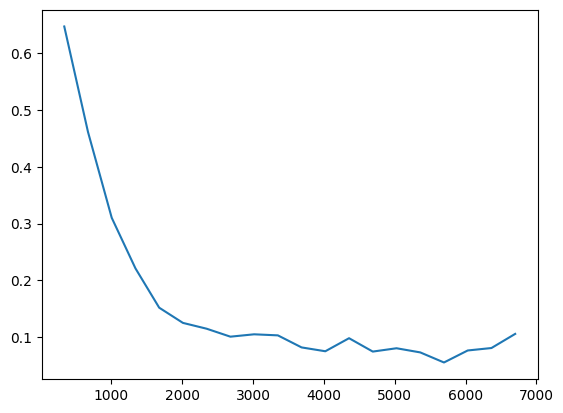

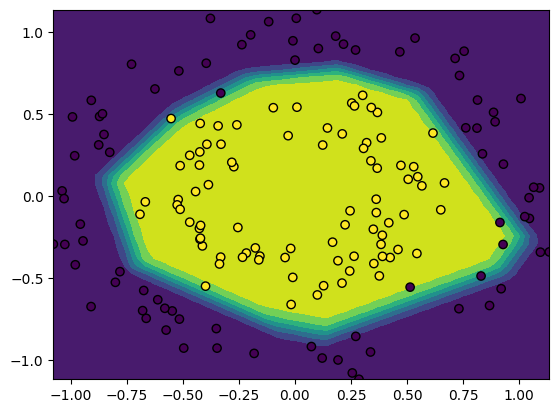

In [85]:
# Optimization
lr = 1e-1
optimizer = torch.optim.SGD(net.parameters(), lr)

learning_curves = model_trainer_binary(net, optimizer, (train_pts, train_labels),
              epochs=20, verbose=True)

# display the loss evolution
plt.figure()
plt.plot(learning_curves[0], learning_curves[1])

display_2D_boundary(net, (test_pts, test_labels), head = torch.sigmoid, pred_show = False)

In [86]:
# Second network (Two hidden layers)
net = NetworkThreeLayers(2, 9, 1, activation=torch.relu)

Loss=8.7395e-02: 100%|██████████| 335/335 [00:01<00:00, 253.95it/s]


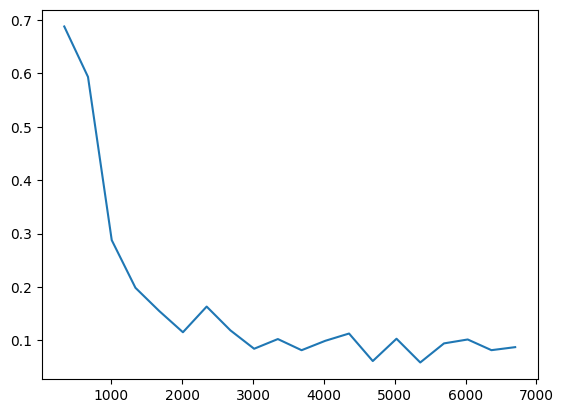

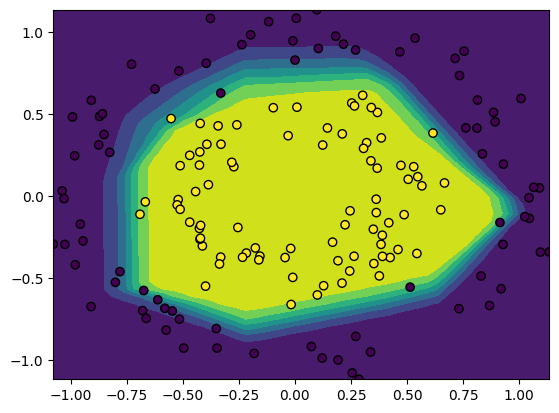

In [87]:
# Optimization
lr = 1e-1
optimizer = torch.optim.SGD(net.parameters(), lr)

learning_curves = model_trainer_binary(net, optimizer, (train_pts, train_labels),
              epochs=20, verbose=True)

# display the loss evolution
plt.figure()
plt.plot(learning_curves[0], learning_curves[1])

display_2D_boundary(net, (test_pts, test_labels), head = torch.sigmoid, pred_show = False)

## Learning parameters: Batch size and momentum



### Batch size

Nous avons vu qu'il est possible d'utiliser des `mini-Batches` de données d'échantillons pour approximer le gradient complet lors de la `SGD`. Dans cette section, nous avons utilisé un mini-Batch de taille 16 au lieu d'un seul point pour chaque itération du gradient. Cela permet d'améliorer l'efficacité de l'apprentissage tout en conservant une bonne approximation de la direction du gradient.



In [92]:
def model_trainer_batch(model, optimizer, data_train, batch_size = 16, epochs=5, verbose=True):

  train_pts = data_train[0]
  train_labels = data_train[1]

  # Epoch: the number of times we see the entire dataset
  num_epoch = epochs

  # optimizer creation
  optimizer = optimizer

  # loss criterion
  criterion = torch.nn.BCEWithLogitsLoss()

  losses = []
  iterations = []
  total_iter_counter = 0
  for epoch in range(num_epoch):
      model.train()
      # create a data iterator with progress bar
      rand_ids = torch.randperm(train_pts.shape[0])
      t = tqdm(range(0, rand_ids.shape[0], batch_size))

      # variable to track the loss
      total_loss = 0

      epoch_iter_counter = 0

      # training loop
      for epoch_iter_counter,i in enumerate(t):

          ids = rand_ids[i:i+batch_size]
          x = train_pts[ids]
          target = train_labels[ids].unsqueeze(1).float()

          # forward
          y2 = model(x)

          # compute error
          loss = criterion(y2, target)

          # initialize the gradients to zero
          optimizer.zero_grad()

          # compute the backward pass
          loss.backward()

          # update the weights
          optimizer.step()

          # get the loss for the example and add it to the total loss
          total_loss += loss.item()

          # print the average loss in the progress bar
          if verbose:
            t.set_description_str(f"Loss={total_loss/(1+epoch_iter_counter):.4e}")

          total_iter_counter += 1

      # Compute the loss over one epoch
      total_loss /= train_pts.shape[0]

      # Increment the loss sequence
      losses.append(total_loss)
      iterations.append(total_iter_counter)

  return (iterations, losses)


In [93]:
#dataset: two moons
idataset = 0

X,y = generate_data(idataset, nsamples=500, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_pts, train_labels = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
test_pts, test_labels = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create network
net = NetworkThreeLayers(2, 8, 1, activation=torch.relu)

Loss=1.6425e-02: 100%|██████████| 21/21 [00:00<00:00, 275.96it/s]


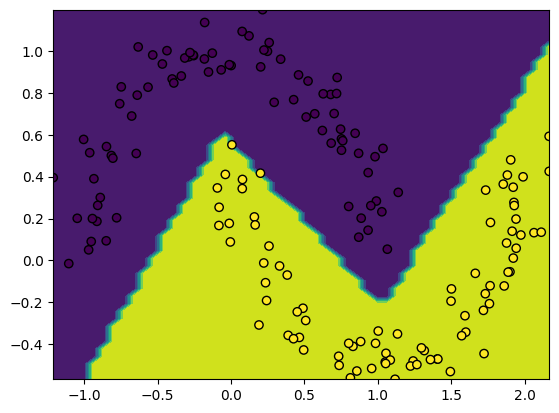

In [95]:
# Optimization
lr = 1e-1
optimizer = torch.optim.SGD(net.parameters(), lr)

learning_curves_batch = model_trainer_batch(net, optimizer, (train_pts, train_labels),
              batch_size = 16, epochs=40, verbose=True)

# display the decision surface
display_2D_boundary(net, (test_pts, test_labels), head = torch.sigmoid, pred_show = True)


Nous avons appliqué cette approche au dataset `Two moons`(Dataset 0). En utilisant un mini-batch, le réseau de neurones est capable de s'ajuster plus rapidement et plus efficacement à la surface de décision, ce qui fait que le modèle se comporte comme un bon séparateur en apprenant à mieux classifier les points, surtout aux frontières du jeu de données.

### Momentum

Selon la taille du **batch**, la descente de gradient peut être instable. Une solution consiste à augmenter la taille du **batch** (comme vu précédemment), mais selon le problème, cela peut ne pas être toujours possible. Une autre approche consiste à utiliser **le momentum** pendant l'optimisation.

La formule du momentum est la suivante :

$$v_t = \gamma v_{t-1} + (1-\gamma) \Delta w $$

$$w_t = w_{t-1} + \alpha v_t $$

### Intuition derrière le momentum :

Le **momentum** dans la descente de gradient permet de "lisser" les mises à jour des poids pour éviter que le modèle ne fasse des oscillations importantes ou ne reste bloqué dans des minima locaux. L'idée est d'introduire un terme d'accumulation (vitesse) dans les mises à jour des poids, qui prend en compte non seulement le gradient actuel, mais aussi l'historique des gradients précédents. Ce terme permet de guider l'optimisation en "accélérant" dans la direction des gradients précédents tout en réduisant les oscillations. Cela aide à accélérer la convergence vers un minimum global ou un bon minimum local.

In [96]:
# Create and initialize network
net = NetworkThreeLayers(2, 8, 1, activation=torch.relu)


Loss=2.1065e-04: 100%|██████████| 335/335 [00:02<00:00, 164.51it/s]


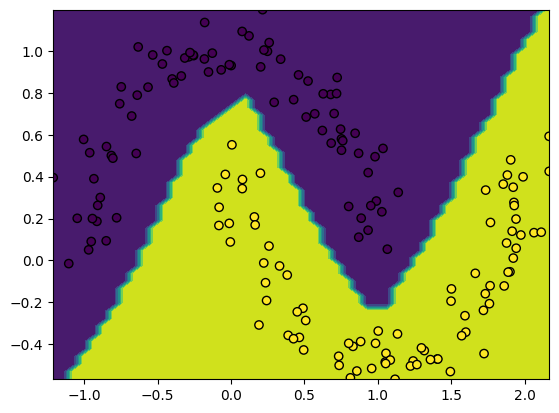

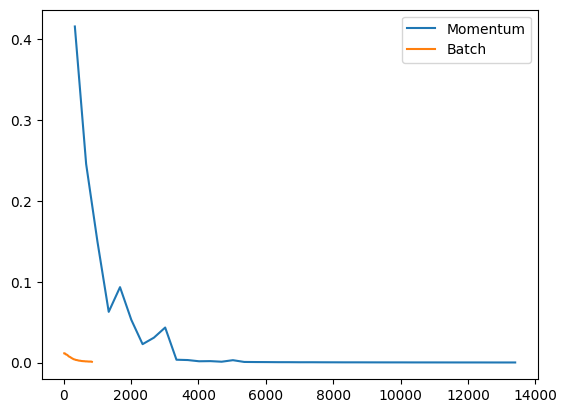

In [97]:
lr = 1e-1
optimizer = torch.optim.SGD(net.parameters(), lr, momentum = 0.1)

learning_curves_momentum = model_trainer_batch(net, optimizer, (train_pts, train_labels),
              batch_size = 1, epochs=40, verbose=True)

# display the decision surface
display_2D_boundary(net, (test_pts, test_labels), head = torch.sigmoid, pred_show = True)

# display the loss evolution
plt.figure()
plt.plot(learning_curves_momentum[0], learning_curves_momentum[1], label='Momentum')
plt.plot(learning_curves_batch[0], learning_curves_batch[1], label='Batch')
plt.legend()


## Comparaison avec un SVM



Best score = 1.00 with kernel rbf
Parameters are gamma = 0.17 and C = 0.215443


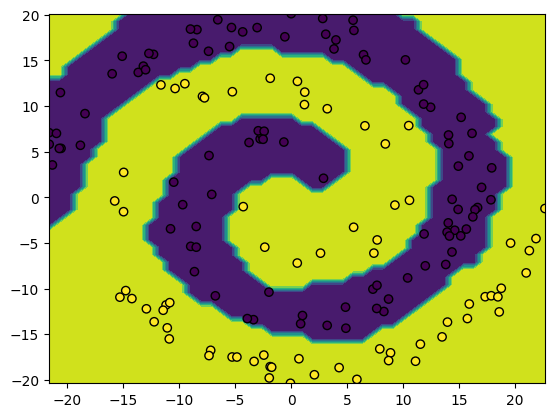

In [98]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# dataset: spiral
idataset = 3
X,y = generate_data(idataset, nsamples=500, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Base classifier for cross-validation
svc = svm.SVC(shrinking=True,max_iter=1000000)

# Cross validation
parameters = [{'kernel':['rbf'],
              'C':np.logspace(-2, 2, 7),
              'gamma':np.logspace(-3, 2, 10)}]

clf = GridSearchCV(svc, parameters, cv=10)
clf.fit(X_train, y_train)

# Result of the cross-validation
bestsvc = clf.best_estimator_

print("Best score = {:.2f} with kernel {}".format(clf.best_score_, bestsvc.kernel))
print("Parameters are gamma = {:.2g} and C = {:2g}".format(bestsvc.gamma, bestsvc.C))

# Display decision surfaces
pt_min = X_test.min(0)
pt_max = X_test.max(0)
feature_1, feature_2 = np.meshgrid(np.linspace(pt_min[0],pt_max[0]),np.linspace(pt_min[1],pt_max[1]))

grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

y_pred = bestsvc.predict(grid)
y_pred = np.reshape(y_pred, feature_1.shape)

display = DecisionBoundaryDisplay(xx0=feature_1,
                                    xx1=feature_2,
                                    response=y_pred)
display.plot()

display.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor="black")


## Classification Multi-label

L'un des grands avantages des réseaux de neurones est de résoudre le problème multi-classes en utilisant une seule fonction de perte à optimiser. Nous présentons ci-dessous un code permettant de résoudre le problème multi-classes.


In [99]:
def model_trainer_batch_multilabel(model, optimizer, data_train, batch_size = 10, epochs=5, verbose=True):

  train_pts = data_train[0]
  train_labels = data_train[1]
  num_epoch = epochs

  # optimizer creation
  optimizer = optimizer

  # loss criterion
  criterion = torch.nn.CrossEntropyLoss()

  losses = []
  iterations = []
  total_iter_counter = 0
  for epoch in range(num_epoch):

      # set the network in training mode
      model.train()

      # create an iterator with progress bar
      rand_ids = torch.randperm(train_pts.shape[0])
      t = tqdm(range(0, rand_ids.shape[0], batch_size))

      # variable to track the loss
      total_loss = 0

      epoch_iter_counter = 0

      # training loop
      for epoch_iter_counter,i in enumerate(t):

          # create the input / target tensors
          ids = rand_ids[i:i+batch_size]
          x = train_pts[ids]
          target = train_labels[ids].long()

          # forward
          y2 = model(x)

          # compute error
          loss = criterion(y2, target)

          # initialize the gradients to zero
          optimizer.zero_grad()

          # compute the backward pass
          loss.backward()

          # update the weights
          optimizer.step()

          # get the loss for the example and add it to the total loss
          total_loss += loss.item()

          # print the average loss in the progress bar
          if verbose:
            t.set_description_str(f"Loss={total_loss/(1+epoch_iter_counter):.4e}")

          total_iter_counter += 1

      total_loss /= train_pts.shape[0]
      losses.append(total_loss)
      iterations.append(total_iter_counter)

  return (iterations, losses)


In [100]:
from sklearn.inspection import DecisionBoundaryDisplay

def display_2D_multilabel(model, # network
                        points # Evaluation data
                        ):

  model.eval()

  pt_min = points[0].min(0).values.numpy()
  pt_max = points[0].max(0).values.numpy()
  feature_1, feature_2 = np.meshgrid(np.linspace(pt_min[0],pt_max[0]),np.linspace(pt_min[1],pt_max[1]))

  grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
  grid_t = torch.tensor(grid, dtype=torch.float32)

  with torch.no_grad():
    pred_test = net(grid_t)
    grid_pred = torch.argmax(pred_test,1)

  y_pred = np.reshape(grid_pred, feature_1.shape)

  display = DecisionBoundaryDisplay(xx0=feature_1,
                                    xx1=feature_2,
                                    response=y_pred)
  display.plot()

  display.ax_.scatter(points[0][:, 0], points[0][:, 1], c=points[1], edgecolor="black")



In [101]:
# Four moons dataset
idataset = 5
X,y = generate_data(idataset, nsamples=500, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_pts, train_labels = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
test_pts, test_labels = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create network
net = NetworkThreeLayers(2, 8, 4, activation=torch.tanh)


Loss=2.1338e-03: 100%|██████████| 21/21 [00:00<00:00, 243.79it/s]


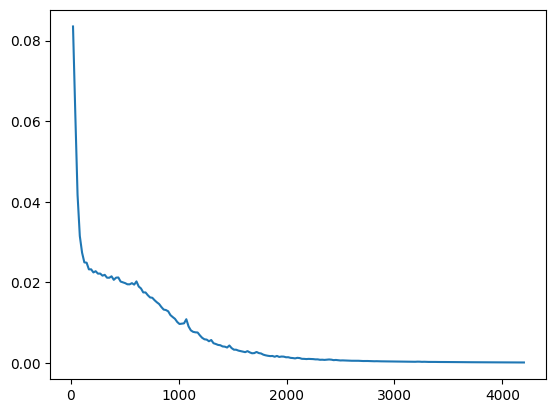

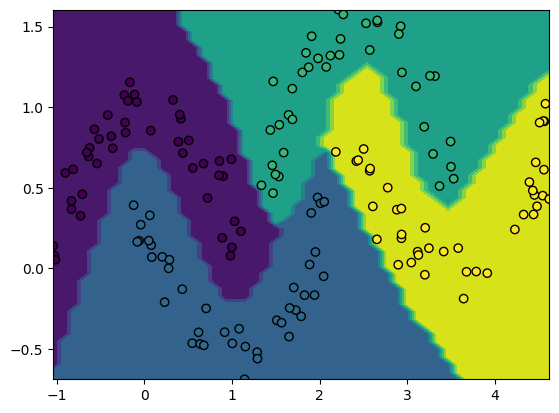

In [102]:

lr = 1e-1; optimizer = torch.optim.SGD(net.parameters(), lr)

# An adaptive learning rate strategy
lr = 1e-2; optimizer = torch.optim.Adam(net.parameters(), lr)

learning_curves = model_trainer_batch_multilabel(net, optimizer, (train_pts, train_labels),
              batch_size = 16, epochs=200, verbose=True)

# display the loss evolution
plt.figure()
plt.plot(learning_curves[0], learning_curves[1])

# display the decision surface
display_2D_multilabel(net, (test_pts, test_labels))